
Training CNN with L2=0.001, Dropout=0.2
Train Acc: 0.8817, Val Acc: 0.8731, Gap: 0.0087, Time: 523.51s

Training CNN with L2=0.001, Dropout=0.5
Train Acc: 0.8589, Val Acc: 0.8661, Gap: -0.0072, Time: 484.05s

Training CNN with L2=0.01, Dropout=0.2
Train Acc: 0.8374, Val Acc: 0.8502, Gap: -0.0129, Time: 473.58s

Training CNN with L2=0.01, Dropout=0.5
Train Acc: 0.8211, Val Acc: 0.8317, Gap: -0.0106, Time: 448.48s

Training CNN with L2=0.1, Dropout=0.2
Train Acc: 0.7619, Val Acc: 0.7786, Gap: -0.0167, Time: 478.21s

Training CNN with L2=0.1, Dropout=0.5
Train Acc: 0.7341, Val Acc: 0.7576, Gap: -0.0235, Time: 470.36s


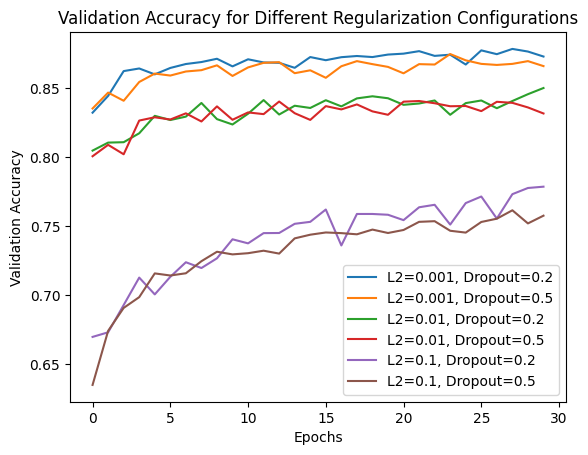

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import time
import matplotlib.pyplot as plt

# Load PCA-reduced data
x_train = np.load('x_train_pca95.npy')
x_val = np.load('x_val_pca95.npy')
x_test = np.load('x_test_pca95.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')

# Reshape to 2D pseudo-image for CNN: 188 → 2 x 94
x_train_cnn = x_train.reshape(-1, 2, 94, 1)
x_val_cnn = x_val.reshape(-1, 2, 94, 1)
x_test_cnn = x_test.reshape(-1, 2, 94, 1)

input_shape = (2, 94, 1)

# Function to create CNN model with regularization
def create_cnn_model(input_shape, l2_lambda=0.01, dropout_rate=0.5):
    model = keras.models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_lambda),
                      input_shape=input_shape, padding='same'),  # Use 'same' padding
        layers.MaxPooling2D((2, 2), padding='same'),  # Use 'same' padding for pooling
        
        layers.Conv2D(64, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_lambda), padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),  # Use 'same' padding for pooling

        layers.Flatten(),
        layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')  # Adjust classes if needed
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameter combinations
l2_lambdas = [0.001, 0.01, 0.1]
dropout_rates = [0.2, 0.5]

results = {}
all_histories = {}

# Train for each combination
for l2 in l2_lambdas:
    for dropout in dropout_rates:
        print(f"\nTraining CNN with L2={l2}, Dropout={dropout}")
        model = create_cnn_model(input_shape=(2, 94, 1), l2_lambda=l2, dropout_rate=dropout)

        start_time = time.time()
        history = model.fit(x_train_cnn, y_train,
                            epochs=30,
                            validation_data=(x_val_cnn, y_val),
                            verbose=0)
        training_time = time.time() - start_time

        # Record results
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        val_loss = history.history['val_loss'][-1]

        results[(l2, dropout)] = {
            'train_acc': train_acc,
            'val_acc': val_acc,
            'val_loss': val_loss,
            'train_time': training_time,
            'overfit_gap': train_acc - val_acc
        }
        all_histories[(l2, dropout)] = history.history

        print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Gap: {train_acc - val_acc:.4f}, Time: {training_time:.2f}s")

# Optionally, visualize the results (example plot for validation accuracy)
for (l2, dropout), history in all_histories.items():
    plt.plot(history['val_accuracy'], label=f'L2={l2}, Dropout={dropout}')
plt.title('Validation Accuracy for Different Regularization Configurations')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()
